In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd
from keras.regularizers import l2
import random
import statsmodels.api as sm
import numpy as np
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
from sklearn.preprocessing import label_binarize
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from functools import reduce
import pickle
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import all_estimators
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [7]:
seed = 42

In [8]:
datos = pd.read_csv('datos.csv')

In [9]:
X, y = datos.drop("Parar", axis="columns"), datos["Parar"]

In [10]:
v_continuas = ['Tiempo_Parada', 'Tiempo_Por_Vuelta', 'Curvas_Lentas', 'Curvas_Medias', 'Curvas_Rápidas', 
                            'Año', 'LapNumber', 'Stint', 'TyreLife', 'TrackStatus', 'Position', 'Tiempo_Antes_Pit', 
                            'Tiempo_Delante', 'Tiempo_Detras', 'TrackTemp']

v_discretas =  ['Evento','Deg_Blando','Deg_Medio','Deg_Duro','Driver','Compound','Team','Piloto_Delante',
                    'Piloto_Detras','Parada_Delante','Parada_Detras', 'Rainfall', 'Tráfico']

print("Variables continuas: ",len(v_continuas))
print("Variables discretas: ",len(v_discretas))

Variables continuas:  15
Variables discretas:  13


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
data_train = pd.concat([X_train, y_train], axis = 1)
data_test = pd.concat([X_test,y_test], axis=1)

In [18]:
type_filter = ["classifier", "transformer"] 

arguments = {"type_filter": type_filter}
estimators = all_estimators(**arguments)
estimators = dict(estimators) 

standarscaler = estimators["StandardScaler"]()

columnTransformerAvanzado = make_column_transformer((standarscaler, v_continuas),
                                                    (OneHotEncoder(), v_discretas))

# RF

In [52]:
param_grid = {
    'randomforestclassifier__n_estimators': [100,300,500],
    'randomforestclassifier__max_depth': [None,5, 15],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [2, 5],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__class_weight': ['balanced']
}
    
rf_model = RandomForestClassifier(random_state=seed)
pipeline = make_pipeline(columnTransformerAvanzado, rf_model)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=5
)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_rf_model = grid_search.best_estimator_

print(f'Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}


In [53]:
joblib.dump(grid_search, 'best_random_forest_model1.pkl')
rf_model1 = joblib.load('best_random_forest_model1.pkl')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     22092
           1       0.29      0.51      0.37       752

    accuracy                           0.94     22844
   macro avg       0.64      0.73      0.67     22844
weighted avg       0.96      0.94      0.95     22844



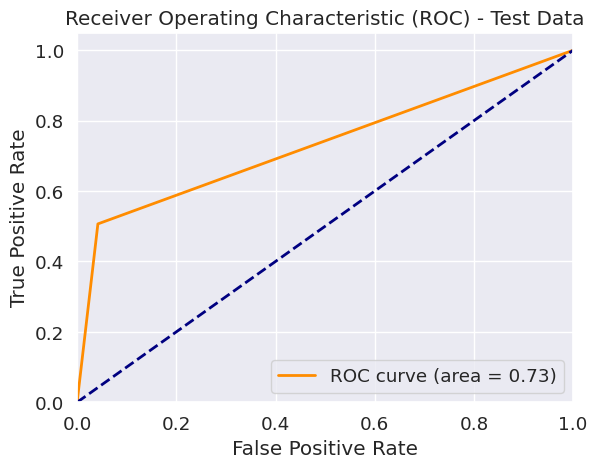

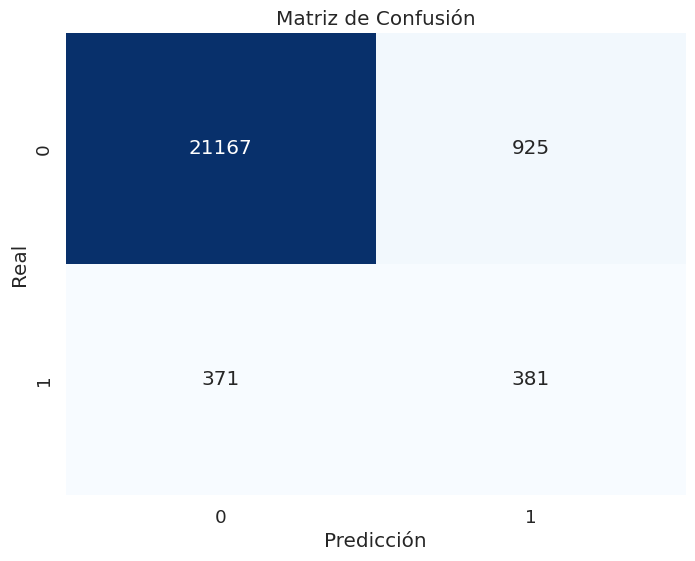

In [54]:
y_pred = rf_model1.predict(X_test)
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
test_classification_rep = classification_report(y_test, y_pred)

print("Test Classification Report:")
print(test_classification_rep)


fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

In [128]:
rf_model1 = joblib.load('modelos/best_random_forest_model1.pkl')

carrera = datos[(datos["Año"] == 2024) & (datos["Evento"] == "Australian Grand Prix")]
y_real = carrera["Parar"].to_numpy()
map_dict = {'no': 0, 'si': 1}
y_real = np.array(list(map(map_dict.get, y_real)))
y_predi = rf_model1.predict(carrera.drop("Parar", axis="columns"))


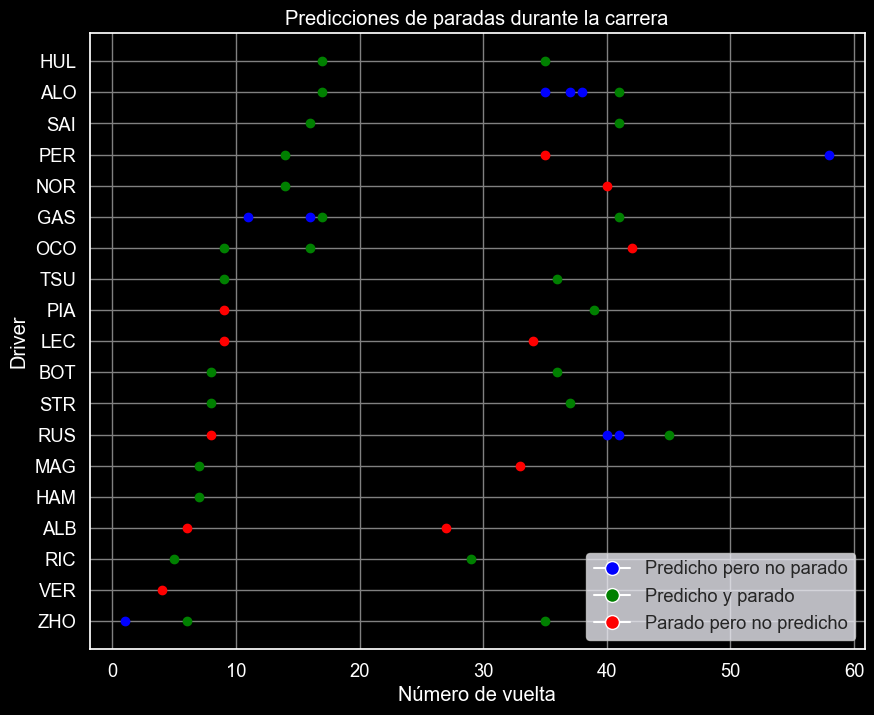

In [129]:
carrera = carrera.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 8))

filtered_carrera = carrera[(y_predi == 1) | (y_real == 1)]

for index, row in filtered_carrera.iterrows():
    driver = row['Driver']
    lap_number = row['LapNumber']
    y_real_value = y_real[index]  
    y_predi_value = y_predi[index] 
    
    if y_predi_value == 1 and y_real_value == 0:
        color = 'blue'
        label = 'Predicho pero no parado'
    elif y_predi_value == 1 and y_real_value == 1:
        color = 'green'
        label = 'Predicho y parado'
    elif y_predi_value == 0 and y_real_value == 1:
        color = 'red'
        label = 'Parado pero no predicho'
    
    ax.scatter(lap_number, driver, color=color)

ax.set_xlabel('Número de vuelta', color='white')
ax.set_ylabel('Driver', color='white')
ax.set_title('Predicciones de paradas durante la carrera', color='white')

ax.set_facecolor('black')

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Predicho pero no parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Predicho y parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Parado pero no predicho')
]

legend = ax.legend(handles=legend_elements, loc='lower right')

frame = legend.get_frame()

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

plt.grid(True, color='gray')

fig.patch.set_facecolor('black')

plt.grid(True)

plt.show()

# SVM

In [ ]:
svm_classifier = SVC(class_weight='balanced')

pipeline = Pipeline([
    ('column_transformer', columnTransformerAvanzado),
    ('svm_classifier', svm_classifier)
])

param_grid = {
    'svm_classifier__C':[0.1, 1, 10],  
    'svm_classifier__gamma': [ 0.1, 1, 3],  
    'svm_classifier__kernel': ['poly', 'rbf'],
    'svm_classifier__decision_function_shape': ['ovr', 'ovo']
}


# Realiza la búsqueda de parámetros mediante validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='weighted'),
    cv=3
)

label_encoder = LabelEncoder()
    
y_train = label_encoder.fit_transform(y_train)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print(f'Mejores hiperparámetros:', best_params)

In [40]:
joblib.dump(grid_search, 'best_svm_model1.pkl')
svm_model1 = joblib.load('best_svm_model1.pkl')

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     22092
           1       0.11      0.66      0.19       752

    accuracy                           0.82     22844
   macro avg       0.55      0.74      0.55     22844
weighted avg       0.96      0.82      0.88     22844



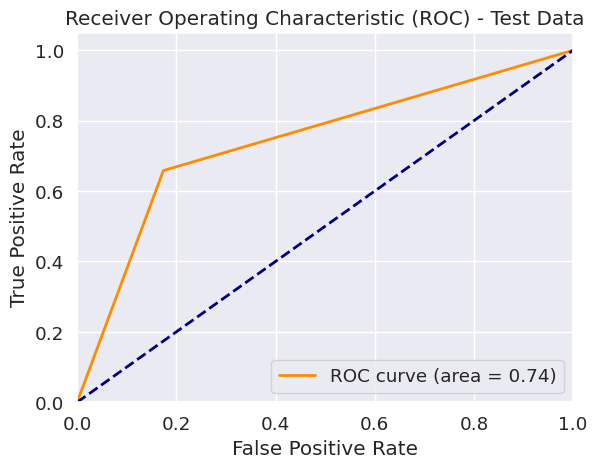

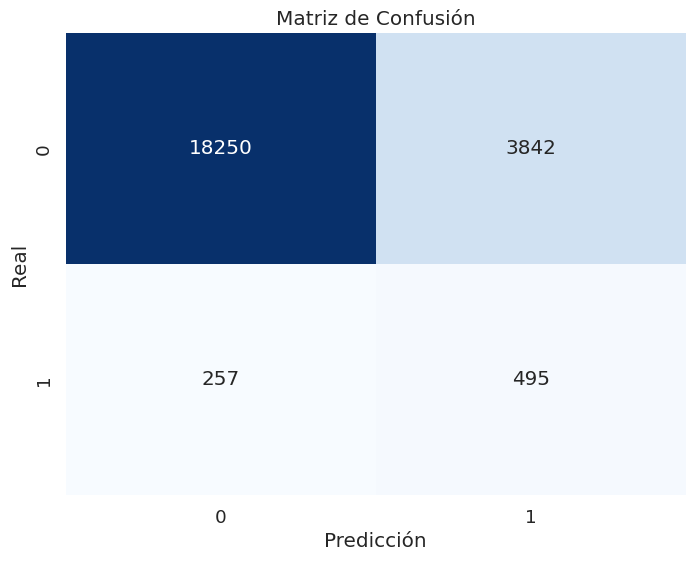

In [77]:
y_pred = svm_model1.predict(X_test)
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
test_classification_rep = classification_report(y_test, y_pred)

print("Test Classification Report:")
print(test_classification_rep)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)

sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

In [130]:
svm_model1 = joblib.load('modelos/best_svm_model1.pkl')

carrera = datos[(datos["Año"] == 2024) & (datos["Evento"] == "Australian Grand Prix")]
y_real = carrera["Parar"].to_numpy()
map_dict = {'no': 0, 'si': 1}
y_real = np.array(list(map(map_dict.get, y_real)))
y_predi = svm_model1.predict(carrera.drop("Parar", axis="columns"))


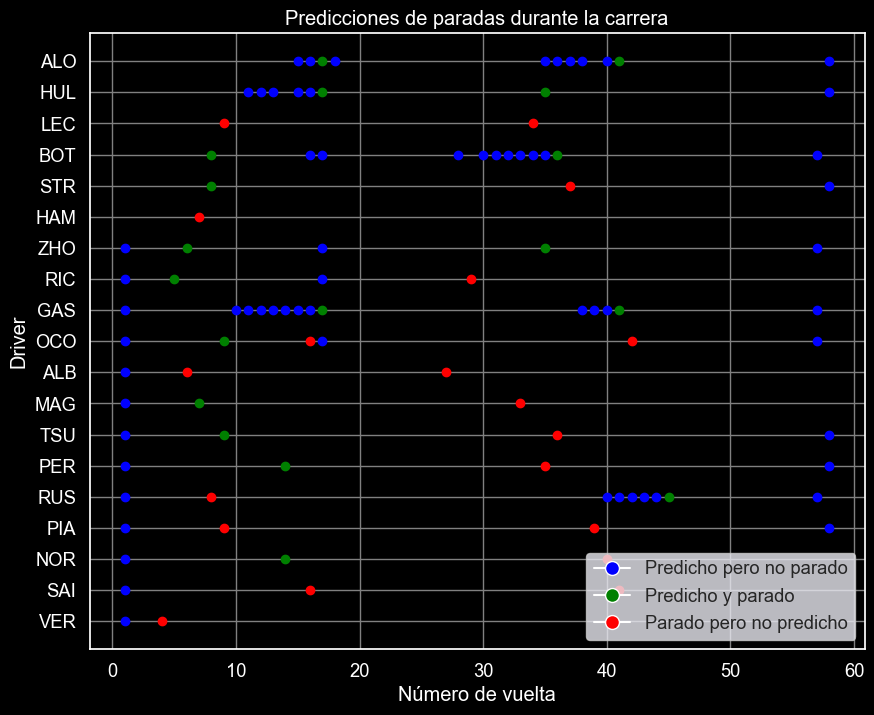

In [131]:
carrera = carrera.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 8))

filtered_carrera = carrera[(y_predi == 1) | (y_real == 1)]

for index, row in filtered_carrera.iterrows():
    driver = row['Driver']
    lap_number = row['LapNumber']
    y_real_value = y_real[index]  
    y_predi_value = y_predi[index] 
    
    if y_predi_value == 1 and y_real_value == 0:
        color = 'blue'
        label = 'Predicho pero no parado'
    elif y_predi_value == 1 and y_real_value == 1:
        color = 'green'
        label = 'Predicho y parado'
    elif y_predi_value == 0 and y_real_value == 1:
        color = 'red'
        label = 'Parado pero no predicho'
    
    ax.scatter(lap_number, driver, color=color)

ax.set_xlabel('Número de vuelta', color='white')
ax.set_ylabel('Driver', color='white')
ax.set_title('Predicciones de paradas durante la carrera', color='white')

ax.set_facecolor('black')

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Predicho pero no parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Predicho y parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Parado pero no predicho')
]

legend = ax.legend(handles=legend_elements, loc='lower right')

frame = legend.get_frame()

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

plt.grid(True, color='gray')

fig.patch.set_facecolor('black')

plt.grid(True)

plt.show()

# RN

In [19]:
X_train_processed = columnTransformerAvanzado.fit_transform(X_train)
X_train_processed_tensor = tf.convert_to_tensor(X_train_processed.todense(), dtype=tf.float32)

X_test_processed = columnTransformerAvanzado.transform(X_test)
X_test_processed_tensor = tf.convert_to_tensor(X_test_processed.todense(), dtype=tf.float32)

In [20]:
label_encoder = LabelEncoder()

# Convertir las etiquetas de clases a números enteros
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [21]:
class_weight_dict = {0: 1, 1: 7.5}
class_weight_dict

{0: 1, 1: 7.5}

In [23]:
X_train_processed_tensor = np.array(X_train_processed_tensor)
y_train_encoded = np.array(y_train_encoded)

In [26]:
def create_model(optimizer='adam', activation='relu', init_mode='glorot_uniform', neurons=256, l2_value=0.01):
    inputs = Input(shape=(X_train_processed_tensor.shape[1],))
    x = Dense(neurons, activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(inputs)
    x = Dense(int(neurons/2), activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(x)
    x = Dense(int(neurons/4), activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(x)
    x = Dense(int(neurons/8), activation=activation, kernel_regularizer=l2(l2_value), kernel_initializer=init_mode)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(model=create_model, verbose=0, optimizer='adam', activation='relu', init_mode='glorot_uniform', neurons=256, l2_value=0.01)


param_grid = {
    'batch_size': [512, 1024, 2048],
    'epochs': [50, 100, 150],
    'activation': ['relu','tanh'],
    'neurons': [128, 256, 512],
    'l2_value': [0.01, 0.001]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train_processed_tensor, y_train_encoded)

print(f"Mejores parámetros: {grid_result.best_params_}")


Mejores parámetros: {'activation': 'relu', 'batch_size': 2048, 'epochs': 100, 'l2_value': 0.01, 'neurons': 256}


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8865 - loss: 5.0179 - val_accuracy: 0.9673 - val_loss: 2.6044
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9616 - loss: 2.5132 - val_accuracy: 0.9578 - val_loss: 1.2839
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9536 - loss: 1.3856 - val_accuracy: 0.9528 - val_loss: 0.7213
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9488 - loss: 0.9212 - val_accuracy: 0.9402 - val_loss: 0.5092
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9463 - loss: 0.7107 - val_accuracy: 0.9494 - val_loss: 0.3925
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9466 - loss: 0.6275 - val_accuracy: 0.9469 - val_loss: 0.3539
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9453 - loss: 0.5794 - val_accuracy: 0.9543 - val_loss: 0.2984
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9404 - loss: 0.5771 - val_accuracy: 0.

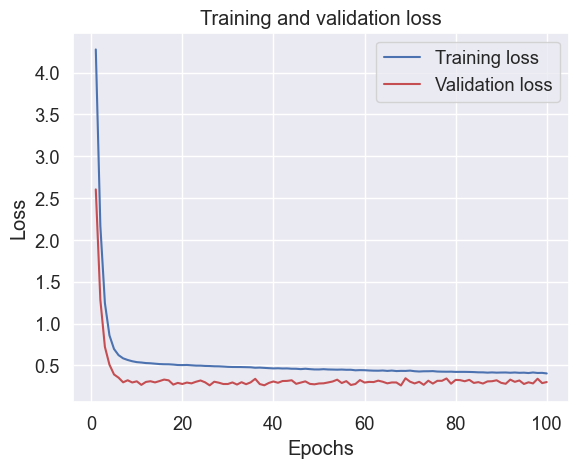

In [136]:
inputs = Input(shape=(X_train_processed_tensor.shape[1],)) 
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x) 
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model_nn1.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='min',
    save_best_only=True)

history = model.fit(X_train_processed_tensor, y_train_encoded,
                    epochs=100,
                    batch_size=2048,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[model_checkpoint_callback])  

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_accuracy) + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

714/714 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Classification Report:
              precision    recall  f1-score   support

          no       0.99      0.92      0.95     22092
          si       0.20      0.60      0.30       752

    accuracy                           0.91     22844
   macro avg       0.59      0.76      0.62     22844
weighted avg       0.96      0.91      0.93     22844



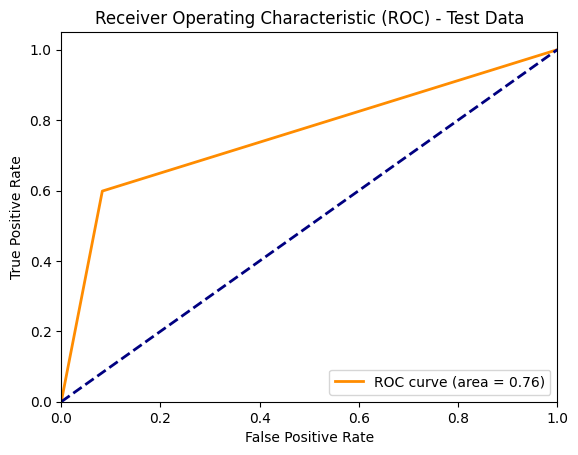

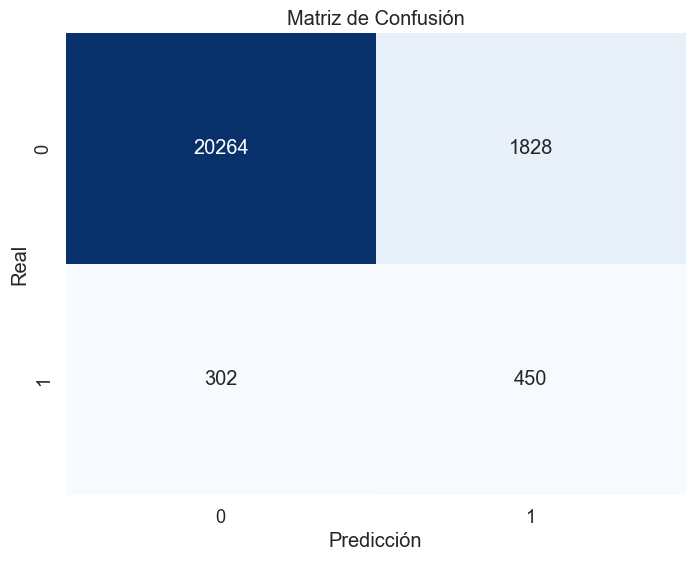

In [38]:
best_model_nn1 = load_model('best_model_nn1.keras')

y_test_pred = best_model_nn1.predict(X_test_processed_tensor)

y_test_pred_classes = (y_test_pred > 0.5).astype(int)

y_test_pred_labels = label_encoder.inverse_transform(y_test_pred_classes)

test_classification_rep = classification_report(y_test, y_test_pred_labels)

print("Test Classification Report:")
print(test_classification_rep)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

pos_label_index = 1
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_test_pred_classes, pos_label=pos_label_index)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(y_test_encoded, y_test_pred_classes)

sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

In [138]:
carrera = datos[(datos["Año"] == 2024) & (datos["Evento"] == "Australian Grand Prix")]

X_train_processed = columnTransformerAvanzado.fit_transform(X_train)
X_train_processed_tensor = tf.convert_to_tensor(X_train_processed.todense(), dtype=tf.float32)

best_model_nn1 = load_model('modelos/best_model_nn1.keras')

y_real = carrera["Parar"].to_numpy()
map_dict = {'no': 0, 'si': 1}
y_real = np.array(list(map(map_dict.get, y_real)))

X_test = carrera.drop("Parar", axis="columns")

X_test_processed = columnTransformerAvanzado.transform(X_test)
X_test_processed_tensor = tf.convert_to_tensor(X_test_processed.todense(), dtype=tf.float32)

y_predi = best_model_nn1.predict(X_test_processed_tensor)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [139]:
y_predi = (y_predi > 0.5).astype(int).flatten()


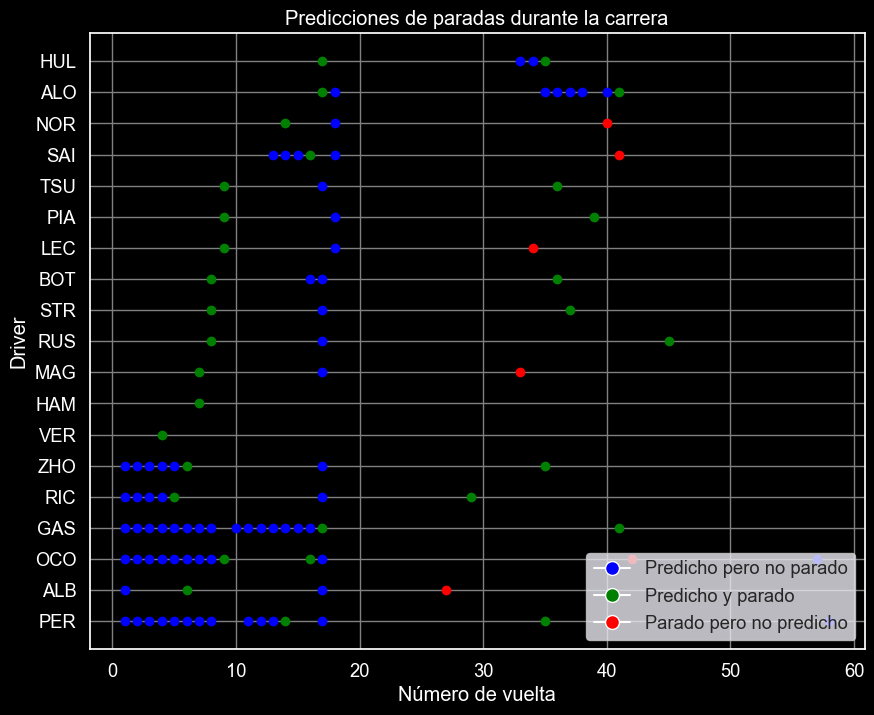

In [140]:
carrera = carrera.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 8))

filtered_carrera = carrera[(y_predi == 1) | (y_real == 1)]

for index, row in filtered_carrera.iterrows():
    driver = row['Driver']
    lap_number = row['LapNumber']
    y_real_value = y_real[index]  
    y_predi_value = y_predi[index] 
    
    if y_predi_value == 1 and y_real_value == 0:
        color = 'blue'
        label = 'Predicho pero no parado'
    elif y_predi_value == 1 and y_real_value == 1:
        color = 'green'
        label = 'Predicho y parado'
    elif y_predi_value == 0 and y_real_value == 1:
        color = 'red'
        label = 'Parado pero no predicho'
    
    ax.scatter(lap_number, driver, color=color)

ax.set_xlabel('Número de vuelta', color='white')
ax.set_ylabel('Driver', color='white')
ax.set_title('Predicciones de paradas durante la carrera', color='white')

ax.set_facecolor('black')

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Predicho pero no parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Predicho y parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Parado pero no predicho')
]

legend = ax.legend(handles=legend_elements, loc='lower right')

frame = legend.get_frame()

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

plt.grid(True, color='gray')

fig.patch.set_facecolor('black')

plt.grid(True)

plt.show()

# Ensemble

In [8]:
rf_model1 = joblib.load('modelos/best_random_forest_model1.pkl')
svm_model1 = joblib.load('modelos/best_svm_model1.pkl')
best_model_nn1 = load_model('modelos/best_model_nn1.keras')

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
data_train = pd.concat([X_train, y_train], axis = 1)
data_test = pd.concat([X_test,y_test], axis=1)

714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Classification Report:
              precision    recall  f1-score   support

          no       0.99      0.93      0.96     22092
          si       0.23      0.59      0.33       752

    accuracy                           0.92     22844
   macro avg       0.61      0.76      0.64     22844
weighted avg       0.96      0.92      0.94     22844



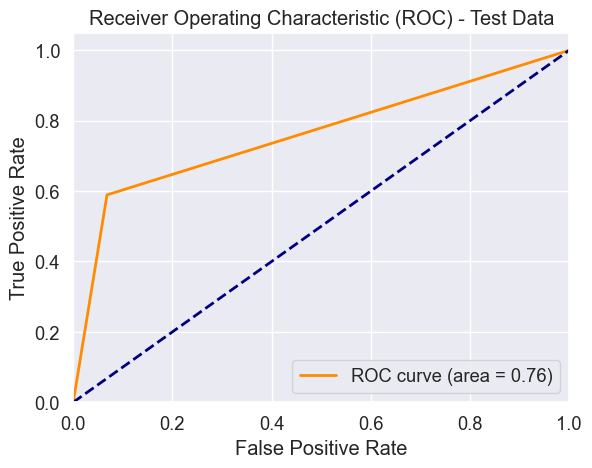

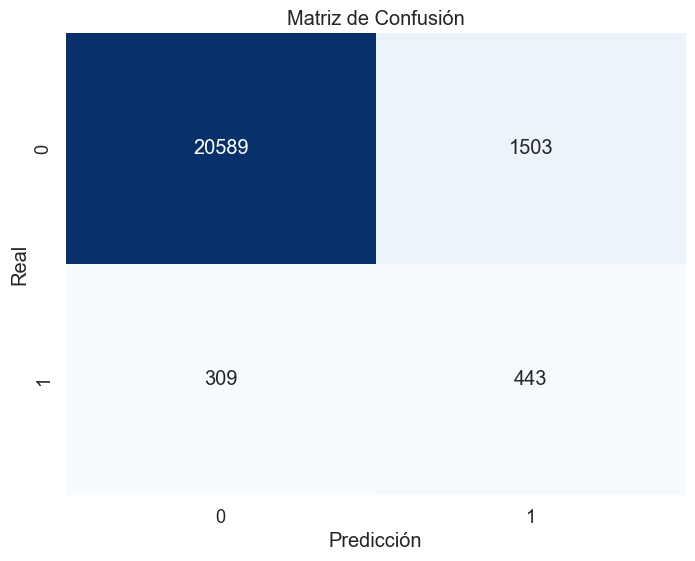

In [138]:
from collections import Counter

rf_predictions = rf_model1.predict(X_test) 
rf_predictions = label_encoder.inverse_transform(rf_predictions)

svm_predictions = svm_model1.predict(X_test)
svm_predictions = label_encoder.inverse_transform(svm_predictions)

y_test_pred = best_model_nn1.predict(X_test_processed_tensor)
nn_predictions= (y_test_pred >= 0.5).astype(int).flatten()
nn_predictions = label_encoder.inverse_transform(nn_predictions)

final_predictions = []

for rf_pred, svm_pred, nn_pred in zip(rf_predictions, svm_predictions, nn_predictions):
    votes = [rf_pred, svm_pred, nn_pred]
    vote_counts = Counter(votes)
    
    
    if vote_counts["no"] > vote_counts["si"]:
        final_predictions.append("no")
    else:
        final_predictions.append("si")
        
        

test_classification_rep = classification_report(y_test, final_predictions)

print("Test Classification Report:")
print(test_classification_rep)

y_test = label_encoder.fit_transform(y_test)
final_predictions = label_encoder.fit_transform(final_predictions)
fpr, tpr, thresholds = roc_curve(y_test,final_predictions, pos_label=1)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Data')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(y_test, final_predictions)

sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

In [139]:
carrera = datos[(datos["Año"] == 2024) & (datos["Evento"] == "Australian Grand Prix")]

In [140]:
rf_model1 = joblib.load('modelos/best_random_forest_model1.pkl')

y_real = carrera["Parar"].to_numpy()
map_dict = {'no': 0, 'si': 1}
y_real = np.array(list(map(map_dict.get, y_real)))
y_pred_rf = rf_model1.predict(carrera.drop("Parar", axis="columns"))

In [141]:
svm_model1 = joblib.load('modelos/best_svm_model1.pkl')

y_real = carrera["Parar"].to_numpy()
map_dict = {'no': 0, 'si': 1}
y_real = np.array(list(map(map_dict.get, y_real)))
y_pred_svm = svm_model1.predict(carrera.drop("Parar", axis="columns"))


In [176]:
X_train_processed = columnTransformerAvanzado.fit_transform(X_train)
X_train_processed_tensor = tf.convert_to_tensor(X_train_processed.todense(), dtype=tf.float32)

best_model_nn1 = load_model('modelos/best_model_nn1.keras')

y_real = carrera["Parar"].to_numpy()
map_dict = {'no': 0, 'si': 1}
y_real = np.array(list(map(map_dict.get, y_real)))

X_test = carrera.drop("Parar", axis="columns")

X_test_processed = columnTransformerAvanzado.transform(X_test)
X_test_processed_tensor = tf.convert_to_tensor(X_test_processed.todense(), dtype=tf.float32)

y_pred_nn = best_model_nn1.predict(X_test_processed_tensor)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [177]:
y_pred_nn= (y_pred_nn >= 0.5).astype(int).flatten()

In [178]:
from collections import Counter
final_predictions = []

for rf_pred, svm_pred, nn_pred in zip(y_pred_rf, y_pred_svm, y_pred_nn):
    votes = [rf_pred, svm_pred, nn_pred]
    vote_counts = Counter(votes)
    
    if vote_counts[0] > vote_counts[1]:
        final_predictions.append(0)
    else:
        final_predictions.append(1)

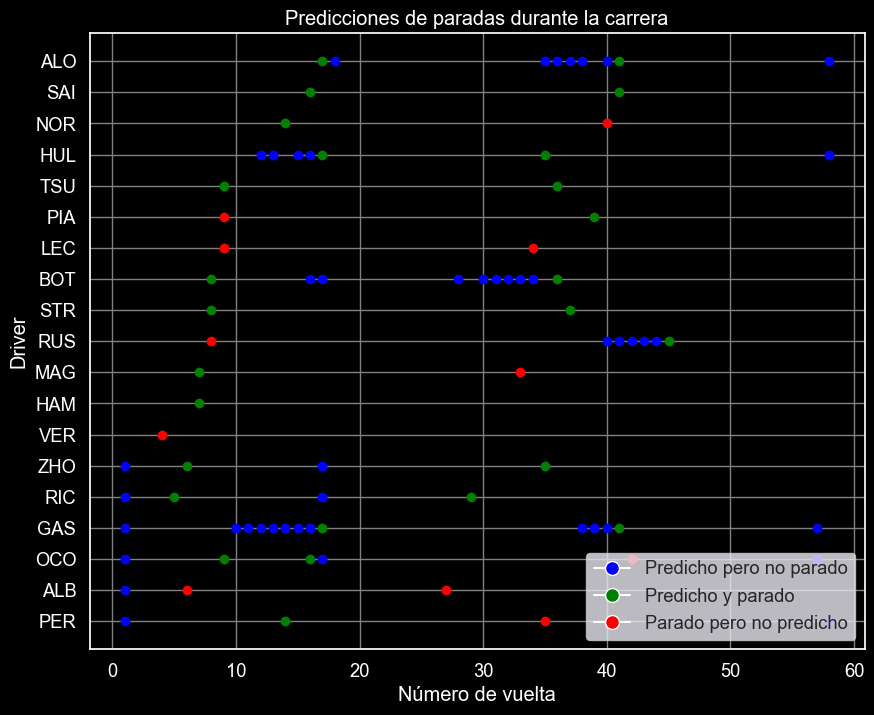

In [199]:
y_predi = np.array(final_predictions)

carrera = carrera.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 8))

filtered_carrera = carrera[(y_predi == 1) | (y_real == 1)]

for index, row in filtered_carrera.iterrows():
    driver = row['Driver']
    lap_number = row['LapNumber']
    y_real_value = y_real[index]  
    y_predi_value = y_predi[index] 
    
    if y_predi_value == 1 and y_real_value == 0:
        color = 'blue'
        label = 'Predicho pero no parado'
    elif y_predi_value == 1 and y_real_value == 1:
        color = 'green'
        label = 'Predicho y parado'
    elif y_predi_value == 0 and y_real_value == 1:
        color = 'red'
        label = 'Parado pero no predicho'
    
    ax.scatter(lap_number, driver, color=color)

ax.set_xlabel('Número de vuelta', color='white')
ax.set_ylabel('Driver', color='white')
ax.set_title('Predicciones de paradas durante la carrera', color='white')

ax.set_facecolor('black')

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Predicho pero no parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Predicho y parado'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Parado pero no predicho')
]

legend = ax.legend(handles=legend_elements, loc='lower right')

frame = legend.get_frame()

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

plt.grid(True, color='gray')

fig.patch.set_facecolor('black')

plt.grid(True)

plt.show()